# Annotate experiments
Notebook used to create binary annotations for experiments using a computer vision approach, or deep networks.  
Manual tuning and correction are used to improve the quality of the detection, before it is used as ground truths.

In [1]:
%matplotlib inline

import os, sys, time, shutil
import warnings
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import clear_output

import numpy as np
import matplotlib.pyplot as plt
from skimage import io, filters, measure
from skimage import morphology as morph
from skimage.morphology import disk

import torch

from utils_common.image import imread_to_float, to_npint, overlay_contours
from utils_common.processing import nlm_denoising
from utils_common.register_cc import register_stack
from computer_vision.cv_detector import cv_detect
from deep_learning.utils_data import normalize_range, pad_transform_stack
from deep_learning.utils_test import predict_stack
# from deep_learning

%load_ext autoreload
%autoreload 2

### Load experiment

In [10]:
animal_to_annotate = os.listdir("/data/talabot/experiments/to_annotate/")
animal_annotated = os.listdir("/data/talabot/experiments/annotated/")

# Randomly select an animal without any annotated experiment
animal = np.random.choice([animal for animal in animal_to_annotate if animal not in animal_annotated])
# Randomly select an experiment to annotated
experiment = np.random.choice(os.listdir(os.path.join("/data/talabot/experiments/to_annotate/", animal)))

animal = "MDN1-3_imaging_MDN1_tdTom-GC6s_fly2"
experiment = "MDN1-3_imaging_MDN1_tdTom-GC6s_fly2_006"
print(animal, experiment, sep="\n")

MDN1-3_imaging_MDN1_tdTom-GC6s_fly2
MDN1-3_imaging_MDN1_tdTom-GC6s_fly2_006


In [11]:
# Load RGB stack and register it
rgb_stack = imread_to_float(os.path.join("/data/talabot/experiments/to_annotate/", animal, experiment, "RGB.tif"))
reg_rgb = register_stack(rgb_stack, ref_num=0)

@interact(image=(0, len(rgb_stack) - 1))
def plot_stack(image=0):
    plt.figure(figsize=(10,5))
    plt.suptitle("Animal: %s\nExp: %s" % (animal, experiment))
    plt.subplot(121)
    plt.title("Raw frame %d" % image)
    plt.imshow(rgb_stack[image])
    plt.subplot(122)
    plt.title("Mean temporal registered image")
    plt.imshow(reg_rgb.mean(0))
    plt.tight_layout()
    plt.show()

interactive(children=(IntSlider(value=0, description='image', max=599), Output()), _dom_classes=('widget-inter…

# Computer Vision detector

In [12]:
# Test the denoising and detector to tune their parameters
print("Denoising")
@interact(image=(0, len(rgb_stack) - 1),
          h_red=widgets.BoundedIntText(value=11, min=0),
          h_green=widgets.BoundedIntText(value=11, min=0))
def plot_denoising(image=0, h_red=11, h_green=11):
    start = time.time()
    denoised = nlm_denoising(rgb_stack, img_id=image, h_red=h_red, h_green=h_green)
    duration = time.time() - start
    
    plt.figure(figsize=(10,5))
    plt.subplot(121)
    plt.title("Raw input")
    plt.imshow(rgb_stack[image])
    plt.subplot(122)
    plt.title("Denoised\n(Took %f s.)" % duration)
    plt.imshow(denoised)
    plt.tight_layout()
    plt.show()

print("Detection")
@interact(image=(2, len(rgb_stack) - 3),
          h_red=widgets.BoundedIntText(value=11, min=0),
          h_green=widgets.BoundedIntText(value=11, min=0),
          thresh_fn=widgets.ToggleButtons(options=["Otsu", "Li", "Constant"]),
          thresh_val=widgets.BoundedIntText(value=30, min=0, max=255),
          erosion=(0,5))
def plot_detector(image=0, h_red=11, h_green=11, thresh_fn="Otsu", thresh_val=30, erosion=0):
    if thresh_fn == "Otsu":
        thresholding_fn = filters.threshold_otsu
    elif thresh_fn == "Li":
        thresholding_fn = filters.threshold_li
    elif thresh_fn == "Constant":
        thresholding_fn = lambda x: thresh_val / 255
    
    start = time.time()
    detection = cv_detect(rgb_stack[image - 2: image + 3], 
                          h_red=h_red, h_green=h_green,
                          thresholding_fn=thresholding_fn, 
                          registration=False, selem=disk(erosion))[2]
    duration = time.time() - start
    
    plt.figure(figsize=(13,5))
    plt.subplot(131)
    plt.title("Raw input")
    plt.imshow(rgb_stack[image])
    plt.subplot(132)
    plt.title("Detection\n(Took %f s.)" % duration)
    plt.imshow(detection)
    plt.subplot(133)
    plt.title("Detection contours")
    plt.imshow(overlay_contours(rgb_stack[image], detection))
    plt.tight_layout()
    plt.show()

Denoising


interactive(children=(IntSlider(value=0, description='image', max=599), BoundedIntText(value=11, description='…

Detection


interactive(children=(IntSlider(value=2, description='image', max=597, min=2), BoundedIntText(value=11, descri…

In [23]:
# Apply detector to the whole stack (/!\ a bit slow)
h_red = 20
h_green = 7
thresholding_fn = filters.threshold_otsu
erosion = 0

start = time.time()
cv_detection = cv_detect(rgb_stack, h_red=h_red, h_green=h_green, thresholding_fn=thresholding_fn, 
                         registration=False, selem=disk(erosion))
duration = time.time() - start
duration_str = "%d min %d s" % (duration // 60, duration % 60)
print("CV detection took %s." % duration_str)

@interact(image=(0, len(cv_detection) - 1))
def plot_detector(image=0):
    plt.figure(figsize=(13,5))
    plt.subplot(131)
    plt.title("Raw input")
    plt.imshow(rgb_stack[image])
    plt.subplot(132)
    plt.title("Detection")
    plt.imshow(cv_detection[image])
    plt.subplot(133)
    plt.title("Detection contours")
    plt.imshow(overlay_contours(rgb_stack[image], cv_detection[image]))
    plt.tight_layout()
    plt.show()

CV detection took 3 min 30 s.


interactive(children=(IntSlider(value=0, description='image', max=599), Output()), _dom_classes=('widget-inter…

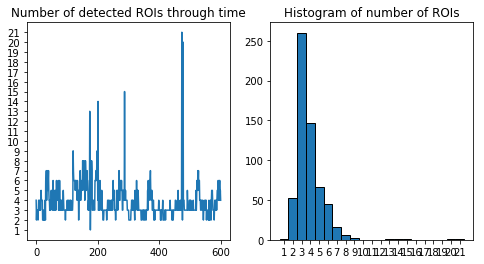

In [25]:
# Plot number of detected ROIs along time
num_roi = np.zeros(len(cv_detection))
for i in range(len(num_roi)):
    num_roi[i] = measure.label(cv_detection[i], connectivity=1, return_num=True)[1]
#     if num_roi[i] != 3:
#         print(i, num_roi[i])

plt.figure(figsize=(8,4))
plt.subplot(121)
plt.title("Number of detected ROIs through time")
plt.plot(num_roi)
plt.yticks(np.arange(num_roi.min(), num_roi.max() + 1))
plt.subplot(122)
plt.title("Histogram of number of ROIs")
plt.hist(num_roi, bins=np.arange(num_roi.min(), num_roi.max() + 2), align='left', edgecolor='k')
plt.xticks(np.arange(num_roi.min(), num_roi.max() + 1))
plt.show()

# Deep learning detector

In [20]:
# model_name = "RG_synth_190311"
# model_name = "unet4-16_RG_cv-annotated_aug"
# model_name = "unet4-16_synth_only_2-6neur_181205"
model_name = "R_synth_only_181205_pixel-weight"

input_channels = "G"
model_dir = "deep_learning/models/"
u_depth = 4
out1_channels = 16
batch_size = 32
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Load model
sys.path.append(os.path.join(model_dir, model_name))
from utils_model_save import CustomUNet as ModelNet

model = ModelNet(len(input_channels), u_depth=u_depth, out1_channels=out1_channels, batchnorm=True, device=device)
model.load_state_dict(torch.load(os.path.join(model_dir, model_name, "model_best.pth")))
model.eval()

# Predict
transform = lambda stack: normalize_range(pad_transform_stack(stack, u_depth))
start = time.time()
predictions = predict_stack(model, rgb_stack, batch_size, input_channels=input_channels, 
                            channels_last=True, transform=transform)
print("Prediction took %.1f s." % (time.time() - start))
predictions = torch.sigmoid(predictions).numpy()

# Display results
@interact(image=(0, len(rgb_stack) - 1),
          detection_th=widgets.FloatSlider(value=0.5, min=0, max=1, step=0.1, readout_format=".1f"))
def plot_detector(image=0, detection_th=0.5):
    detection = predictions[image] > detection_th
    
    plt.figure(figsize=(10,10))
    plt.subplot(221)
    plt.title("Raw input")
    plt.imshow(rgb_stack[image])
    plt.subplot(222)
    plt.title("Detection contours")
    plt.imshow(overlay_contours(rgb_stack[image], detection, rescale_img=True))
    plt.subplot(223)
    plt.title("Prediction probabilities")
    plt.imshow(predictions[image])
    plt.subplot(224)
    plt.title("Detection")
    plt.imshow(detection)
    plt.tight_layout()
    plt.show()

Device: cuda:0
Prediction took 0.9 s.


interactive(children=(IntSlider(value=0, description='image', max=599), FloatSlider(value=0.5, description='de…

In [21]:
# Make final predictions
dl_detection_th = 0.5

dl_detection = predictions > dl_detection_th
@interact(image=(0, len(rgb_stack) - 1))
def plot_detector(image=0):    
    plt.figure(figsize=(12,6))
    plt.subplot(121)
    plt.title("Raw input")
    plt.imshow(rgb_stack[image])
    plt.subplot(122)
    plt.title("Detection")
    plt.imshow(dl_detection[image])
    plt.tight_layout()
    plt.show()

interactive(children=(IntSlider(value=0, description='image', max=599), Output()), _dom_classes=('widget-inter…

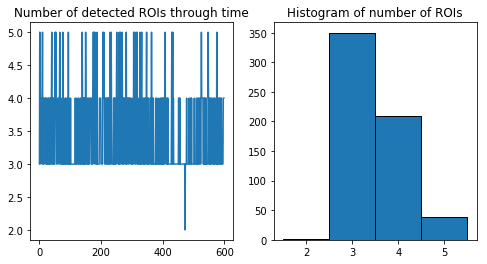

In [34]:
# Plot number of detected ROIs along time
num_roi = np.zeros(len(dl_detection))
for i in range(len(num_roi)):
    num_roi[i] = measure.label(dl_detection[i], connectivity=1, return_num=True)[1]
#     if num_roi[i] != 3:
#         print(i, num_roi[i])
# print(np.sum(num_roi > 4))

plt.figure(figsize=(8,4))
plt.subplot(121)
plt.title("Number of detected ROIs through time")
plt.plot(num_roi)
plt.subplot(122)
plt.title("Histogram of number of ROIs")
plt.hist(num_roi, bins=np.arange(num_roi.min(), num_roi.max() + 2), align='left', edgecolor='k')
plt.xticks(np.arange(num_roi.min(), num_roi.max() + 1))
plt.show()

# Select and tune best results
Compare results of detector, manually tune/correct them, etc.

In [26]:
cv_processed = np.zeros_like(cv_detection)
dl_processed = np.zeros_like(dl_detection)
for i in range(len(rgb_stack)):
    cv_processed[i] = morph.remove_small_objects(cv_detection[i], min_size=16)
    dl_processed[i] = morph.remove_small_objects(dl_detection[i], min_size=16)

@interact(image=(0, len(rgb_stack) - 1))
def plot_detector(image=0):    
    plt.figure(figsize=(10,10))
    plt.subplot(221)
    plt.title("Raw input")
    plt.imshow(rgb_stack[image])
    plt.subplot(222)
    plt.title("Red input")
    plt.imshow(rgb_stack[image,...,0])
    plt.subplot(223)
    plt.title("CV processed")
    plt.imshow(cv_processed[image])
    plt.subplot(224)
    plt.title("DL processed")
    plt.imshow(dl_processed[image])
    plt.tight_layout()
    plt.show()

interactive(children=(IntSlider(value=0, description='image', max=599), Output()), _dom_classes=('widget-inter…

In [36]:
pre_processed = dl_processed.copy()
processed = pre_processed.copy()

# Plot number of detected ROIs along time
num_roi = np.zeros(len(processed))
for i in range(len(num_roi)):
    labels, num_roi[i] = measure.label(processed[i], connectivity=1, return_num=True)
    if num_roi[i] <= 4:
        continue
    plt.figure(figsize=(10,5))
    plt.suptitle("Frame %d" % i)
    plt.subplot(121)
    plt.imshow(rgb_stack[i])
    plt.subplot(122)
    plt.imshow(labels)
    plt.colorbar()
    plt.tight_layout()
    plt.show()
    for region in measure.regionprops(labels):
        print(region.label, region.area)
    choice = input("Which to delete ? (0 for nothing): ")
    for c in choice.split(",")[0]:
        c = int(c)
        if c > 0:
            processed[i][labels == c] = 0
            print("Label %d is set to background." % c)
        else:
            print("Nothing is done.")
    # Label with more than one digit
    for c in choice.split(",")[1:]:
        c = int(c)
        if c > 0:
            processed[i][labels == c] = 0
            print("Label %d is set to background." % c)
        else:
            print("Nothing is done.")
    time.sleep(1)
    clear_output()

@interact(image=(0, len(rgb_stack) - 1))
def plot_detector(image=0):    
    plt.figure(figsize=(10,10))
    plt.subplot(221)
    plt.title("Raw input")
    plt.imshow(rgb_stack[image])
    plt.subplot(222)
    plt.title("Red input")
    plt.imshow(rgb_stack[image,...,0])
    plt.subplot(223)
    plt.title("Before processing")
    plt.imshow(pre_processed[image])
    plt.subplot(224)
    plt.title("After processing")
    plt.imshow(processed[image])
    plt.tight_layout()
    plt.show()

interactive(children=(IntSlider(value=0, description='image', max=599), Output()), _dom_classes=('widget-inter…

In [12]:
processed2 = np.zeros_like(processed)
for i in range(len(processed)):
    labels = measure.label(processed[i], connectivity=1)
    regions = measure.regionprops(labels)
    
    for region in regions:
        if region.area > 200:
            processed2[i] = np.maximum(processed2[i], morph.binary_erosion(labels == region.label, disk(1)))
        else:
            processed2[i] = np.maximum(processed2[i], labels == region.label)

@interact(image=(0, len(rgb_stack) - 1))
def plot_detector(image=0):    
    plt.figure(figsize=(10,10))
    plt.subplot(221)
    plt.title("Raw input")
    plt.imshow(rgb_stack[image])
    plt.subplot(222)
    plt.title("Overlay with after")
    plt.imshow(overlay_contours(rgb_stack[image], processed2[image], rescale_img=True))
    plt.subplot(223)
    plt.title("Before processing")
    plt.imshow(processed[image])
    plt.subplot(224)
    plt.title("After processing")
    plt.imshow(processed2[image])
    plt.tight_layout()
    plt.show()

interactive(children=(IntSlider(value=0, description='image', max=599), Output()), _dom_classes=('widget-inter…

187 5.0
473 2.0
0


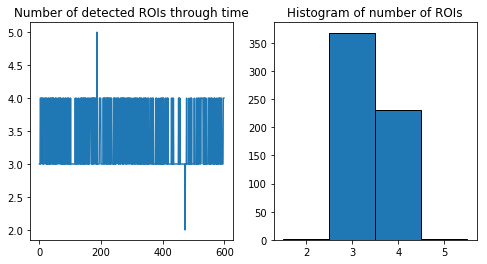

In [38]:
# Plot number of detected ROIs along time
num_roi = np.zeros(len(processed))
for i in range(len(num_roi)):
    num_roi[i] = measure.label(processed[i], connectivity=1, return_num=True)[1]
    if num_roi[i] == 5 or num_roi[i] == 2:
        print(i, num_roi[i])

print(np.sum(num_roi > 5))
plt.figure(figsize=(8,4))
plt.subplot(121)
plt.title("Number of detected ROIs through time")
plt.plot(num_roi)
plt.subplot(122)
plt.title("Histogram of number of ROIs")
plt.hist(num_roi, bins=np.arange(num_roi.min(), num_roi.max() + 2), align='left', edgecolor='k')
plt.xticks(np.arange(num_roi.min(), num_roi.max() + 1))
plt.show()

# Save final detection
Save the final detection as ground truths segmentation and move the corresponding experience folder to the annotated directory.